# Credit Card Customer Churn Prediction Modeling

## Overview

Banks marketing teams invest a large amount of money for acquiring new credit card customers by launching lots of campaigns and offers, so it's crucial to retain existing customers.

Effective predictive ML models enables the business to pro-actively identify the risk of customer churn and provide any required offers to prevent customer churn.

## Approach

In order to achieve objective, I will follow below **CRISP-DM** framework steps

As part of this modeling notebook, will cover steps from 5 to 10 and for EDA please refer [EDA notebook](creditcard-customer-churn-prediction-EDA.ipynb)

1. **Business Understanding :** Define and understand the business problem 
2. **Data Understanding :** Understand the credit card input dataset and derive statistical inferences
3. **Data Preparation :** 
    - Perform required high level data cleaning techniques
4. **Exploratory Data Analysis(EDA) :** Perform the EDA on credit card dataset
    - Categorical feature distributions
    - Numerical feature distributions
    - Feature vs Target variable relationships
    - Correlation Analysis
    - Finalizing the Feature list
5. **Prediction Modeling :**
    - *Feature Engineering* :
        - Pre processing
        - Encoding
          - Robust Scalar Encoding
          - Onehot Encoding (For nominal categorical type features)
          - Ordinal Encoding (For ordinal categorical type features)
        - Splitting into training and testing sets
    - *Predictive Modeling*
        - Model selection approach
        - Model evaluation measures
        - Model Evaluation criteria
        - Training linear and tree based models (like Decision Tree/Gradient Boosting/Random Forest/LGBM)
        - Training with cross validation
6. **Model Performance Evaluation :**
    - Evaluate the performances of linear and tree based classification model scores and finalize the best model
7. **Hyperparameter Tuning :**
    - Tuning by using RandomizedSearchCV
    - Tuning by using Bayesian Optimization
8. **Results :**
    - Individual feature impact on finalized LGBM model prediction
9. **Future Work :**
10. **Conclusion :**
    - Business sugessions

## 5. Prediction Modeling

In [12]:
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

# Libraries for feature engineering and modeling

# For feature engineering/pre processing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# For modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Feature selection
from sklearn.feature_selection import RFE

# For model perf measurement
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

### 5.1 Feature Engineering 

In [15]:
#### Common Classes
class ColumnDropperTransformer():
    '''
        Column Dropping Tranformer 
    '''
    def __init__(self,columns):
        '''
         Constructore Arguments:
            columns: column list which needs to be dropped
        '''
        self.columns=columns

    def transform(self,X,y=None):
        '''
        Dataframe transformer

        X: Input dataframe

        returns: dataframe post dropping the given list of columns
        '''
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        '''
        Identity method
        '''
        return self 

    def get_feature_names_out(self, feature_names):
        return [col for col in feature_names if col not in self.columns]

#### 5.1.1 Pre Processing

In [18]:
# read processed data
credicard_df=pd.read_csv('../data/bank_churners_updated.csv')
credicard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

In [20]:
credicard_df.head()

,Unnamed: 0,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


##### Drop un necessary features
Based on EDA, we have observed that `gender` and `avg_open_to_buy` have no impact on churn, so these can dropped


##### Transforming the feature values

In [24]:
credicard_df['income_category'].unique()

array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
       '$120K +', 'Unknown'], dtype=object)

In [26]:
credicard_df['education_level'].unique()

array(['High School', 'Graduate', 'Uneducated', 'Unknown', 'College',
       'Post-Graduate', 'Doctorate'], dtype=object)

In [28]:
credicard_df['card_category'].unique()

array(['Blue', 'Gold', 'Silver', 'Platinum'], dtype=object)

In [30]:
income_category_mapping = {'Less than $40K': '[$0K_$40K)', '$40K - $60K': '[$40K_$60K)', 
                           '$60K - $80K': '[$60K_$80K)', '$80K - $120K': '[$80K_$120K)',
                           '$120K +': '[$120K_infi)','Unknown':'Unknown'
                          }
credicard_df.loc[:, 'income_category'] = credicard_df['income_category'].replace(income_category_mapping)

#### transforming the target variable into int type

In [33]:
# updating the attrition_flag to binary 0/1 flag
attrition_mapping = {'Existing Customer': 0, 'Attrited Customer': 1}
credicard_df.loc[:, 'attrition_flag'] = credicard_df['attrition_flag'].replace(attrition_mapping)
# As we know all the df attrition flag values are convertable to int without any loss
credicard_df['attrition_flag'] = pd.to_numeric(credicard_df['attrition_flag'], errors='coerce').fillna(0).astype(int)
credicard_df['attrition_flag'].unique()

array([0, 1])

##### Dropping the un necessary features


In [36]:
features_to_drop = ['avg_open_to_buy', 'gender','Unnamed: 0']
credicard_df = credicard_df.drop(columns=features_to_drop, axis=1)

In [38]:
credicard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   attrition_flag            10127 non-null  int64  
 1   customer_age              10127 non-null  int64  
 2   dependent_count           10127 non-null  int64  
 3   education_level           10127 non-null  object 
 4   marital_status            10127 non-null  object 
 5   income_category           10127 non-null  object 
 6   card_category             10127 non-null  object 
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  contacts_count_12_mon     10127 non-null  int64  
 11  credit_limit              10127 non-null  float64
 12  total_revolving_bal       10127 non-null  int64  
 13  total_amt_chng_q4_q1      10127 non-null  float64
 14  total_

### 5.1.2 Encoding

In [41]:
nominal_features = ['marital_status']

ordinal_features = ['income_category', 'education_level', 'card_category']

# low to high 
income_category_order = ['Unknown', '[$0K_$40K)', '[$40K_$60K)', '[$60K_$80K)', '[$80K_$120K)',  '[$120K_infi)']
education_category_order = ['Unknown', 'Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate']
card_category_order = ['Blue', 'Silver', 'Gold', 'Platinum']

numerical_features = [
                        'customer_age',
                        'dependent_count', 
                        'months_on_book', 
                        'total_relationship_count', 
                        'months_inactive_12_mon', 
                        'contacts_count_12_mon', 
                        'credit_limit', 
                        'total_revolving_bal',  
                        'total_amt_chng_q4_q1', 
                        'total_trans_amt', 
                        'total_trans_ct', 
                        'total_ct_chng_q4_q1']

# features to drop
column_dropping_transformer = Pipeline(steps=[
    ('columns_dropper_tranformation', ColumnDropperTransformer(features_to_drop))
])


# numerical feature transformer
numerical_transformer = Pipeline(steps=[
    ('standard_scaling_endoder', StandardScaler())
])

min_max_scaler_transformation = Pipeline(steps=[
    ('min_max_scaler', MinMaxScaler())
])

robust_scaler_transformation = Pipeline(steps = [
    ('robust_scaler', RobustScaler(with_centering=False, with_scaling=True))
])


# categorical feature transformer
nominal_feature_transformer = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

# For ordinal categorigacal features
ordinal_encoding_transformer = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder(categories=[income_category_order, education_category_order, card_category_order]))
])

# Bundle preprocessing for numerical and categorical data
# robust_scaler
preprocessor = ColumnTransformer(
    transformers=[
        ('scaled', robust_scaler_transformation, numerical_features),
        ('onehot', nominal_feature_transformer, nominal_features),
        ('label', ordinal_encoding_transformer, ordinal_features),
        ], remainder='passthrough', verbose_feature_names_out=False
    )

credicard_df_transformed_array = preprocessor.fit_transform(credicard_df)
credicard_df_new = pd.DataFrame(credicard_df_transformed_array, columns = preprocessor.get_feature_names_out())
credicard_df_new.shape

(10127, 21)

In [43]:
credicard_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_age              10127 non-null  float64
 1   dependent_count           10127 non-null  float64
 2   months_on_book            10127 non-null  float64
 3   total_relationship_count  10127 non-null  float64
 4   months_inactive_12_mon    10127 non-null  float64
 5   contacts_count_12_mon     10127 non-null  float64
 6   credit_limit              10127 non-null  float64
 7   total_revolving_bal       10127 non-null  float64
 8   total_amt_chng_q4_q1      10127 non-null  float64
 9   total_trans_amt           10127 non-null  float64
 10  total_trans_ct            10127 non-null  float64
 11  total_ct_chng_q4_q1       10127 non-null  float64
 12  marital_status_Divorced   10127 non-null  float64
 13  marital_status_Married    10127 non-null  float64
 14  marita

In [45]:
credicard_df_new.head()

,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,...,total_ct_chng_q4_q1,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown,income_category,education_level,card_category,attrition_flag,avg_utilization_ratio
0,4.090909,1.5,4.333333,2.5,1.0,3.0,1.490866,0.545263,5.855263,0.442468,...,6.885593,0.0,1.0,0.0,0.0,3.0,2.0,0.0,0.0,0.061
1,4.454545,2.5,4.888889,3.0,1.0,2.0,0.969868,0.606316,6.758772,0.499323,...,15.737288,0.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0,0.105
2,4.636364,1.5,4.000000,2.0,1.0,0.0,0.401527,0.000000,11.377193,0.729839,...,9.885593,0.0,1.0,0.0,0.0,4.0,4.0,0.0,0.0,0.000
3,3.636364,2.0,3.777778,1.5,4.0,1.0,0.389192,1.766316,6.162281,0.452910,...,9.885593,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.760
4,3.636364,1.5,2.333333,2.5,1.0,0.0,0.554009,0.000000,9.539474,0.315606,...,10.593220,0.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.000


In [47]:
credicard_df_new['attrition_flag'].unique()

array([0., 1.])

#### 5.1.3 Split into Training and Testing datasets

In [50]:
X = credicard_df_new.drop(columns=['attrition_flag'], axis=1)
y = credicard_df_new['attrition_flag'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [52]:
print(f'Train dataset [ X_train size : {X_train.shape}, y_train size : {y_train.size}]')
print(f'Test dataset [ X_test size : {X_test.shape}, y_test size : {y_test.size}]')

Train dataset [ X_train size : (8101, 20), y_train size : 8101]
Test dataset [ X_test size : (2026, 20), y_test size : 2026]


### 5.2 Churn Predction Modeling Pipeline

#### 5.2.1 Model Selection Approach 

##### **Considerable Classification Models For This Use Case** 

| Classification Model | Reason for considering |
|:---|:---:|
| Logistic Regression | Easy to interpret and helps business to understand why customers are churning |
| Decision Tree | Can capture non-linear relationships |
| Random Forest | Reduces the overfitting and improves the accuracy by combining the multiple decision trees|
| Ensemble Methods <ul><li>AdaBoost</li><li>GBM</li><li>XGBoost</li><li>LightGBM</li></ul> | Achieves High Accuracy | 


##### **Model Evaluations Measures**

| Evaluation Metric | Definition |
|:---|:---:|
| Accuracy | The overall correctness of the model's predictions |
| Precision | The proposition of correctly predicted churned customers out of **all** customers predicted as churned |
| Recall | The proportion of correctly predicted churned customers out of all **actual** churned customers |
| F1-Score | The harmonic mean of precision and recall, provides a balanced measure for performance | 
| ROC-AUC | A measure of the model's ability to distinguish between customers across different probability thresholds | 

##### **Model Evaluation Criteria**

- **False Negatives:** Model predicts the customer will *not* churn, but actually the customer churns
  - These increases the missed opportunities for banks has direct impact on revenue loss prevention
- **False Positives:** Model predicts the customer will churn, but actually the customer will *not* churn
  - These incurs un necessary operational overhead

##### **Aligning With Business Requirements**
Based on above definitions, our clear goals for models selection criteria are
- **Reduce** False Negatives, which selecting the model with high **recall** 
- Select the best performing model, so that bank can take required marketing steps to prevent potential customer churn prevention
  - So focus on model performance and hyper parameter tuning
- Also provide business insights regarding why customers are churning, so that banks can plan for required steps

#### 5.2.2 Common Model Functions 

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lightgbm



def train_evaluate_classification_model(model, X_train, X_test, y_train, y_test):
    """
    Trains the given model and captures the model performance metricsmance metrics.

    Parameters:
        model: An unfitted scikit-learn classification model instance.
        X_train: Training features dataframe
        X_test: Testing features dataframe
        y_train: Training dataframe with target variable
        y_test: Testing dataframe with target variable

    Returns:
        A dataFrame containing performance metrics (accuracy, precision, recall,
        f1-score, roc_auc_score and confusion matrix, classification report.
    """
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Note: ROC AUC is typically used for binary classification.
    # For multi-class classification, you may need to specify average='ovr' or 'weighted'
    # or use multi-class ROC AUC implementations if available in the library.
    # We'll include a placeholder for binary classification for completeness.
    try:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    except AttributeError:  # Handle models that don't have predict_proba
        roc_auc = None

    perf_metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc_score": roc_auc
    }
    return (perf_metrics, conf_matrix, class_report)


def train_models(models, model_results, X_train, X_test, y_train, y_test):
    '''
    Trains the list of provided classification models
    
    Parameters:
        model: An unfitted scikit-learn classification model instance
        model_results: Dictionary of trained model performance results
        X_train: Training features dataframe
        X_test: Testing features dataframe
        y_train: Training dataframe with target variable
        y_test: Testing dataframe with target variable

    Returns:
        model_results: A dictionary containing performance metrics (accuracy, precision, recall,
        f1-score, roc_auc_score and confusion matrix, classification report.
    '''
    for model in models:
        (perf_metrics, conf_matrix, class_report) = train_evaluate_classification_model(models[model], X_train, X_test, y_train, y_test)
        model_results[model] = perf_metrics
    return model_results


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

def cross_validation_model_tranformations(models, X, y, kcv, scoring_metrics, model_results):
    '''
    Trains the list of provided classification models with cross validation
    
    Parameters:
        model: An unfitted scikit-learn classification model instance
        model_results: Dictionary of trained model performance results
        X: Training features dataframe
        y: Testing features dataframe
        kcv: Number of folds for cross validation
        scoring_metrics: List of scoring metrics

    Returns:
        model_results: A dictionary containing performance metrics (accuracy, precision, recall,
        f1-score, roc_auc_score and confusion matrix, classification report.
    '''
    for model in models:
        print(f'Applying Cross Validation for  {model}')
        cv_scores = cross_validate(models[model], X, y, scoring=scoring_metrics, cv=kcv, return_train_score=True)
        cv_mean_results = {}
        for key in cv_scores.keys():
            cv_mean_results[f'{key}_mean'] = np.round(np.mean(cv_scores[key]), 6)
        model_results[model] = cv_mean_results
        #print(f'model_results : {model_results}')
    return model_results

#### 5.2.3 Applying the Classification Models

In [66]:
# Defining the list of models
results = {}

clf_models = {
    'Logistic Regression' : LogisticRegression(),
    'Decistion Tree' : DecisionTreeClassifier(random_state=42),
    'Random Forest' : RandomForestClassifier(random_state=42),
    'GBM': GradientBoostingClassifier(random_state=42),
    'Adaboost': AdaBoostClassifier(random_state=42),
    'Xgboost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'Light GBM': lightgbm.LGBMClassifier(random_state=42, verbosity=-1)
}

model_perf_results = train_models(clf_models, results, X_train, X_test, y_train, y_test)
model_perf_results
pd.DataFrame.from_dict(model_perf_results, orient='index')

,accuracy,precision,recall,f1_score,roc_auc_score
Logistic Regression,0.901777,0.895146,0.901777,0.893407,0.912603
Decistion Tree,0.938796,0.939274,0.938796,0.939021,0.890124
Random Forest,0.954590,0.953764,0.954590,0.952958,0.984233
GBM,0.963968,0.963849,0.963968,0.962701,0.987374
Adaboost,0.953603,0.952506,0.953603,0.952618,0.981092
Xgboost,0.963968,0.963327,0.963968,0.963279,0.992495
Light GBM,0.968904,0.968437,0.968904,0.968396,0.992699


#### 5.2.4 Applying Cross Validation Scores 

In [69]:
folds = 10
kcv = KFold(n_splits=folds, random_state=42, shuffle=True)
cross_validation_results = {}
scorings = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
cross_validation_results = cross_validation_model_tranformations(clf_models, X, y, kcv, scorings, cross_validation_results)
pd.DataFrame.from_dict(cross_validation_results, orient='index')

Applying Cross Validation for  Logistic Regression
Applying Cross Validation for  Decistion Tree
Applying Cross Validation for  Random Forest
Applying Cross Validation for  GBM
Applying Cross Validation for  Adaboost
Applying Cross Validation for  Xgboost
Applying Cross Validation for  Light GBM


,fit_time_mean,score_time_mean,test_accuracy_mean,train_accuracy_mean,test_precision_macro_mean,train_precision_macro_mean,test_recall_macro_mean,train_recall_macro_mean,test_f1_macro_mean,train_f1_macro_mean,test_roc_auc_mean,train_roc_auc_mean
Logistic Regression,0.041794,0.004687,0.902933,0.903810,0.841011,0.843255,0.771524,0.773680,0.799526,0.802134,0.921847,0.923598
Decistion Tree,0.046742,0.003006,0.939272,1.000000,0.887911,1.000000,0.887273,1.000000,0.887234,1.000000,0.887273,1.000000
Random Forest,0.666998,0.014241,0.962477,0.999989,0.949492,0.999993,0.907028,0.999966,0.926497,0.999980,0.988095,1.000000
GBM,1.261468,0.004676,0.966427,0.974633,0.951885,0.966472,0.920918,0.937949,0.935383,0.951500,0.990011,0.994459
Adaboost,0.265162,0.008007,0.957640,0.961237,0.928955,0.935666,0.910982,0.918259,0.919563,0.926673,0.984819,0.989223
Xgboost,0.053996,0.004289,0.971168,1.000000,0.952356,1.000000,0.939808,1.000000,0.945770,1.000000,0.993809,1.000000
Light GBM,0.111218,0.005282,0.971068,0.999397,0.954274,0.998650,0.937192,0.999115,0.945319,0.998882,0.993978,0.999997


## 6. Model Performance Evaluation

Based on Cross Validation Results trainging and testing scores
- Light GBM is the best model with respect to `test recall score`=*0.937* and `train recall score`=*0.999*
- Xgboost is also pretty close but it's train recall is *1.0* so mostly struggling with overfitting
- The next best model is GBM w.r.t `test recall score`=0.921

## 7. Hyperparameter Tuning

### Tuning By Using RandomizedSearchCV

In [74]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

def hyperparam_tuing(model,X_train, y_train, param_dist, n_iter, cv, scoring):
    '''
        model : Model for which RandomizedSerachCV needs to be applied
        param_dist: Input param distributions for SearchCV
        n_iter: Number of tiers
        cv: Cross Validation Folds
        scoring: Intended score to use for SearchCV optimization

        Returns:
            best_params_ : List of tuned hyperparams
            best_score_: Best score
    '''
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=n_iter, cv=cv, scoring=scoring)
    random_search.fit(X_train, y_train)
    return (random_search.best_params_, random_search.best_score_)

#### XGBoost Classifier Tuning

In [76]:
# Hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(4, 7, 12),
    'n_estimators':stats.randint(50, 250),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5)
}

# XGBoost model object
xgb_model = xgb.XGBClassifier()

(best_params, best_score) = hyperparam_tuing(xgb_model, X_train, y_train , param_dist, 10, 5, 'recall')
print("Best set of hyperparameters  for XGBClassifier: ", best_params)
print("Best score: ", best_score)

Best set of hyperparameters  for XGBClassifier:  {'learning_rate': 0.05429443565752971, 'max_depth': 18, 'n_estimators': 196, 'subsample': 0.8456484336291479}
Best score:  0.8878573533745946


#### LGBM Tuning

In [78]:
grid_params = {
    'max_depth': [2, 5, 8, 15],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5]
}

lgb_model = lightgbm.LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1)


(best_params, best_score) = hyperparam_tuing(xgb_model, X_train, y_train , param_dist, 10, 5, 'recall')
print("Best set of hyperparameters  for LGBMClassifier: ", best_params)
print("Best score: ", best_score)

Best set of hyperparameters  for LGBMClassifier:  {'learning_rate': 0.09426614966474973, 'max_depth': 18, 'n_estimators': 175, 'subsample': 0.6001482708177934}
Best score:  0.8924756852343059


#### Applying these hyperparameter tunings to both XGB and LGBM

In [80]:
tuned_clf_models = {
    'Xgboost': XGBClassifier(random_state=42,
                             learning_rate=0.07759162058961663, 
                             max_depth=16,
                             n_estimators=220,
                             subsample=0.7628042341964377),
    'Light GBM': lightgbm.LGBMClassifier(random_state=42, 
                                         reg_lambda=0.0, 
                                         reg_alpha=0.0, 
                                         n_estimators=194, 
                                         max_depth=16, 
                                         learning_rate=0.06894569250654219, 
                                         subsample=0.7030220369901519,
                                         verbosity=-1)
}
tuned_cross_validation_results = {}
tuned_cross_validation_results = cross_validation_model_tranformations(tuned_clf_models, X, y, kcv, scorings, tuned_cross_validation_results)
pd.DataFrame.from_dict(tuned_cross_validation_results, orient='index')

Applying Cross Validation for  Xgboost
Applying Cross Validation for  Light GBM


,fit_time_mean,score_time_mean,test_accuracy_mean,train_accuracy_mean,test_precision_macro_mean,train_precision_macro_mean,test_recall_macro_mean,train_recall_macro_mean,test_f1_macro_mean,train_f1_macro_mean,test_roc_auc_mean,train_roc_auc_mean
Xgboost,0.223986,0.006792,0.97255,1.0,0.957192,1.0,0.940115,1.0,0.948171,1.0,0.993548,1.0
Light GBM,0.193390,0.006623,0.97245,1.0,0.955996,1.0,0.941019,1.0,0.948134,1.0,0.994385,1.0


### Model Tuning by using Bayesian optimization

As `GridSearchCV` and `RandomizedSearchCV` computationally expensive, so choosing *Bayesian optimization* for tuning

#### XGBoost Classifier

In [85]:
#%pip install hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Hyperparameter space
space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

# Objective function to minimize the loss function
def objective(params):
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    score = recall_score(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters for XGBClassifier: ", best_params)

100%|██████| 100/100 [00:08<00:00, 12.04trial/s, best loss: -0.8707692307692307]
Best set of hyperparameters for XGBClassifier:  {'learning_rate': 0.13257472177440668, 'max_depth': 12, 'subsample': 0.9837057421055491}


In [86]:
# 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'num_leaves': 63, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1
tuned_clf_models = {
    'Xgboost': XGBClassifier(random_state=42, eval_metric='logloss', learning_rate=0.10998145653268011, max_depth=7, subsample=0.5468375595731814)
}
tuned_cross_validation_results = {}
tuned_cross_validation_results = cross_validation_model_tranformations(tuned_clf_models, X, y, kcv, scorings, tuned_cross_validation_results)
pd.DataFrame.from_dict(tuned_cross_validation_results, orient='index')

Applying Cross Validation for  Xgboost


,fit_time_mean,score_time_mean,test_accuracy_mean,train_accuracy_mean,test_precision_macro_mean,train_precision_macro_mean,test_recall_macro_mean,train_recall_macro_mean,test_f1_macro_mean,train_f1_macro_mean,test_roc_auc_mean,train_roc_auc_mean
Xgboost,0.074441,0.009289,0.971266,0.997027,0.953344,0.99491,0.938996,0.994061,0.945807,0.994484,0.99342,0.999907


## 8. Results

- Based on the above results, as LGBM is outperforming across other classification models, so finalizing this model for credit card churn prediction
- Just to note `RandomizedSearchCV` and `Bayesian optimization` hyperparameter tuning,test/validation scores improved for both LGBM and XGB models
  - Also we can observe that for Xgboost, the overfitting issue got resolved

### 8.1 Each Individual Feature on LGBM Model Prediction

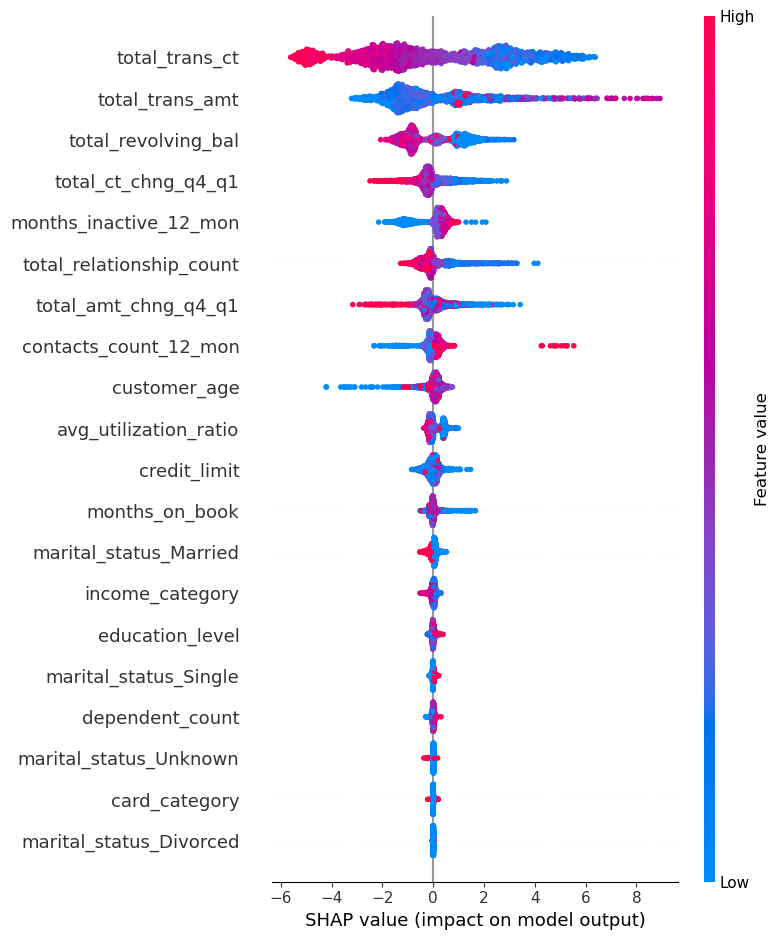

In [89]:
#%pip install shap
import shap

lgb_model = lightgbm.LGBMClassifier(random_state=42, 
                                         reg_lambda=0.0, 
                                         reg_alpha=0.0, 
                                         n_estimators=194, 
                                         max_depth=16, 
                                         learning_rate=0.06894569250654219, 
                                         subsample=0.7030220369901519,
                                         verbosity=-1)
lgb_model.fit(X_train, y_train)
shap_values = shap.TreeExplainer(lgb_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### 8.2 Results Summary
Below are the list of features by their churn prediction impact (By high influence to low influence)
- **total_trans_ct:** Negatively impacted, the lower the value the higher chances to get churned 
- **total_trans_amt:** Negatively impacted, the lower the value the higher chances to get churned 
- **total_revolving_bal:** Negatively impacted, the lower the value the higher chances to get churned 
- **total_amt_chng_q4_q1:** Negatively impacted, the lower the value the higher chances to get churned 
- **months_inactive_12_mon:** Positively impacted, the higher the value the higher the chances to get churned
- **total_relationship_count:** Negatively impacted, the lower the value the higher chances to get churned 
- **total_amt_chng_q4_q1:** Negatively impacted, the lower the value the higher chances to get churned 
- Remaining all features don't have much impact on prediction 

## 9. Future Work

- Explore more on Hyperparameter tuning for LGBM to optimize the `recall` metric
- Explore more on SHAP library for more detailed feature understanding for providing feature impact summary to business

## 10. Conclusion

- LGBM is the best model for prediction
- Bank should engage with customers with less transaction count
 - Provide more cashback offers, so that customer will get more engaged and it reduces the chances of churn
 - Provide more offers for the customers who is inactive in past 12 months